# STOCHASTIC SCENARIO TESTS
<a id="0"></a> <br>

This test checks the consistency of a market-consistent and risk-neutral output from an Economic Scenario Generator (ESG). The goal of this script is to:


- Verify if average performance of the stochastic output is consistent with the deterministic equivalent as implied by the risk-neutral property

- Preform a series of Martingale tests using multiple investment strategies

 # Table of Contents  
 1. [Description of the stochastic scenario tests](#1)
 2. [Success criteria definition](#2)
 3. [Data requirements](#3)
 4. [External dependencies](#4)
 5. [Import data](#5)
 6. [Data manipulation](#6)
 7. [Deterministic scenarios preparation](#7)
 8. [Stochastic scenarios preparation](#8)
 9. [Currency and indices selection](#9)
 10. [Stochastic scenarios filter](#10)
 11. [Stochastic deflator performance calculation](#11)
 12. [Test 1; Mean of stochastic deflator is equal to the deterministic](#12)
 13. [Test 1; Success criteria](#13)
 14. [Spot curve cumulative performance](#14)
 15. [Martingale tests](#15)
 16. [Test 2; Forward return with a spread of 1-year investment strategy](#16)
 17. [Test 2; Success criteria](#17)
 18. [Test 3; Buy-and-hold investment strategy](#18)
 19. [Test 3.1;Spot rate 1-year term](#19)
 20. [Test 3.1; Success criteria](#20)
 21. [Test 3.2; Spot rate 2 year term](#21)
 22. [Test 3.2; Success criteria](#22)
 23. [Test 4; Total-return index](#23)
 24. [Test 4; Success criteria](#24)
 25. [Conclusion](#25)

<a id="1"></a> <br>
## Description of the stochastic scenario tests
 1.  Average of the stochastic deflator is equal to the deterministic deflator 
 2.  Martingale test for a Forward return with `1`-year spread strategy using sport rates
 3.  Martingale test for a Buy-and-hold strategy with sport rates
 4.  Martingale test for a Buy-and-hold strategy with a total-return index

#### Limitations of the implementation
This implementation has the following limitations:

 - The data is assumed to have a monthly granularity

 - This implementation only looks at a subset of all scenarios

 - Only one currency at a time is checked 

 - Only one set of deterministic/stochastic scenario pairs are used

 - Only one total-return index is used

 - Only two spot rates with term `1`-and `2`-years are considered

The accounting convention used is that all months are assumed to be of equal length and represent exactly `1/12` of a year.

Note that the <i>Extra content</i> sections contain plots for the spot curve with up to the `5`-year term.

<a id="2"></a> <br>
## Success criteria definition
The following success criteria is proposed:

-  Difference between the average of stochastic deflator curve and the deterministic deflator is never larger than `300`bps

-  Average difference between the average of stochastic deflator curve and the deterministic deflator is never larger than `500`bps

- The maximum difference between the theoretical and observed return of a Martingale strategy is not larger than `100`bps

- Average difference between the theoretical and observed return of a Martingale strategy is not larger than `50`bps


In [509]:
test_threshold_max = 0.03
test_threshold_mean = 0.05

In [510]:
test_martingale_threshold_max = 0.01
test_martingale_threshold_mean = 0.005

In [511]:
def success_test(test_statistics, threshold_max, threshold_mean):
    out1 = False
    out2 = False
    if max(test_statistics)<threshold_max:
        print("Test passed")
        out1 = True
    else:
        print("Test failed")

    if np.mean(test_statistics)<threshold_mean:
        print("Test passed")
        out2 = True
    else:
        print("Test failed")
    return [out1, out2]

[Back to the top](#0)
<a id="3"></a> <br>

## Data requirements

To perform this test, the following data was provided:

-  Deterministic curves:
        File:TEST_DATA_DETERMINISTIC.csv

-  Stochastic scenario:
        File:TEST_DATA_STOCHASTIC.csv

[Back to the top](#0)
<a id="4"></a> <br>
         
## External dependencies

This implementation uses three well established Python packages widely used in the financial industry. Pandas (https://pandas.pydata.org/docs/), Numpy (https://numpy.org/doc/), and Matplotlib (https://matplotlib.org/stable/index.html).

In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

[Back to the top](#0)
<a id="5"></a> <br>

### Importing data

Two input files are used in this test.

In [516]:
file_det = 'TEST_DATA_DETERMINISTIC.csv'
file_stoch = 'TEST_DATA_STOCHASTIC.csv'

In [517]:
data_det_raw = pd.read_csv(file_det, sep=',', index_col=0)

In [518]:
data_stoch_raw = pd.read_csv(file_stoch, sep=',', index_col=0, low_memory=False)

[Back to the top](#0)
<a id="6"></a> <br>

## Data manipulation

This step converts the raw data from the input file into a format that can be digested by the testing framework.

To uniquely identify the correct scenarios, 4 header types are used:
 1. Description ex. DEFLATOR ASSET, SPOT RATE, ...
 2. Term ex. 1, 2, 3 , ...
 3. Currency ex. EUR, USD, GBP, ...
 4. Scenario number ex. 0, 1, 2, ...

The dataset of both deterministic and stochastic scenarios is filtered for desired curves. The filtering is done using the filter_scenario_file() function to avoid duplication of code:

In [522]:
def filter_scenario_file(data, mydescription, myterm, mycurrency):
    description_row = data.iloc[0,:]
    term_row =  data.iloc[1,:]
    currency_row = data.iloc[2,:]
    true_description = description_row.eq(mydescription, level=None)
    true_term = term_row.eq(myterm, level=None)
    true_currency = currency_row.eq(mycurrency, level=None)
    out = true_description * true_term * true_currency
    out = out.tolist()        
    return out

***
<span style=color:black>
    <b>RUN PARAMETER</b>
</span>
<br>
<span style=color:black>   
    Currency selection
</span>

In [524]:
currency = "EUR"

***

In both files, the currency denominated deflator asset can be identified by:

In [527]:
deflator_variable = "DEFLATOR ASSET"
deflator_term = "0"

The currency denominated spot rates can be identified by:

In [529]:
spot_variable = "SPOT RATE"

Note that the term of the spot curve can vary between the tests.

The currency denominated total-return index can be identified by:

In [532]:
index_variable = "INDEX"
index_term = "0"

[Back to the top](#0)
<a id="7"></a> <br>

### Deterministic scenario preparation

This subsection splits the raw file containing the deterministic scenarios into two tables. The first one contains the headers that are used to identify individual scenarios. The second one contains the numeric data. 

In [535]:
data_det_headers = data_det_raw.iloc[:4,:]

Numeric data is extracted and transposed such that the time runs across rows as is expected by the testing framework.

In [537]:
data_det = data_det_raw.iloc[4:,:].astype(float)

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Deterministic headers and scenario data 
</span>

In [571]:
data_det_headers.head()

,DEFLATOR,SPOT_1,SPOT_2,SPOT_3,SPOT_4,SPOT_5,INDEX
VARIABLE_KEY,,,,,,,
DESCRIPTION,DEFLATOR ASSET,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,INDEX
TERM,0,1,2,3,4,5,0
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,0,0,0,0,0,0,0


In [572]:
data_det.head()

,DEFLATOR,SPOT_1,SPOT_2,SPOT_3,SPOT_4,SPOT_5,INDEX
VARIABLE_KEY,,,,,,,
30/09/2022,1.000000,0.025484,0.028942,0.029624,0.030070,0.030430,1.000000
31/10/2022,0.998170,0.026134,0.029381,0.029853,0.030273,0.030593,1.001861
30/11/2022,0.996310,0.026804,0.029787,0.030077,0.030467,0.030751,1.003674
31/12/2022,0.994414,0.027485,0.030155,0.030293,0.030650,0.030900,1.005618
31/01/2023,0.992476,0.028166,0.030483,0.030499,0.030821,0.031041,1.007612


***

[Back to the top](#0)
<a id="8"></a> <br>

### Stochastic scenarios preparation

This subsection splits the raw file containing the stochastic scenarios into two tables. One with descriptive headers and the other one with numeric data.

In [576]:
data_stoch_headers = data_stoch_raw.iloc[:4,:]

In [577]:
data_stoch = data_stoch_raw.iloc[4:,:].astype(float)

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Stochastic headers and scenario data 
</span>

In [590]:
data_stoch_headers.head()

,DEFLATOR,SPOT_1,SPOT_2,SPOT_3,SPOT_4,SPOT_5,INDEX,DEFLATOR.1,SPOT_1.1,SPOT_2.1,...,SPOT_4.498,SPOT_5.498,INDEX.498,DEFLATOR.499,SPOT_1.499,SPOT_2.499,SPOT_3.499,SPOT_4.499,SPOT_5.499,INDEX.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
DESCRIPTION,DEFLATOR ASSET,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,INDEX,DEFLATOR ASSET,SPOT RATE,SPOT RATE,...,SPOT RATE,SPOT RATE,INDEX,DEFLATOR ASSET,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,INDEX
TERM,0,1,2,3,4,5,0,0,1,2,...,4,5,0,0,1,2,3,4,5,0
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,1,1,1,1,1,1,1,2,2,2,...,499,499,499,500,500,500,500,500,500,500


In [591]:
data_stoch.head()

,DEFLATOR,SPOT_1,SPOT_2,SPOT_3,SPOT_4,SPOT_5,INDEX,DEFLATOR.1,SPOT_1.1,SPOT_2.1,...,SPOT_4.498,SPOT_5.498,INDEX.498,DEFLATOR.499,SPOT_1.499,SPOT_2.499,SPOT_3.499,SPOT_4.499,SPOT_5.499,INDEX.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,1.000000,0.025484,0.028942,0.029624,0.030070,0.030430,1.000000,1.000000,0.025484,0.028942,...,0.030070,0.030430,1.000000,1.000000,0.025484,0.028942,0.029624,0.030070,0.030430,1.000000
31/10/2022,0.998170,0.025951,0.029216,0.029703,0.030137,0.030470,1.004252,0.998170,0.024965,0.028254,...,0.029700,0.030045,0.989699,0.998170,0.022864,0.026205,0.026774,0.027288,0.027698,1.011132
30/11/2022,0.996326,0.026256,0.029277,0.029602,0.030025,0.030339,1.013114,0.996408,0.023438,0.026530,...,0.021411,0.021956,0.997647,0.996583,0.019003,0.022206,0.022726,0.023335,0.023829,1.007644
31/12/2022,0.994477,0.024064,0.026857,0.027118,0.027591,0.027951,1.019324,0.994793,0.023999,0.026794,...,0.022387,0.022887,1.006041,0.995337,0.014633,0.017664,0.018178,0.018892,0.019486,1.009948
31/01/2023,0.992825,0.024050,0.026521,0.026690,0.027154,0.027509,1.022011,0.993146,0.026649,0.029053,...,0.025759,0.026152,1.007956,0.994471,0.017642,0.020277,0.020618,0.021247,0.021761,1.011125


***

[Back to the top](#0)
<a id="9"></a> <br>

## Currency and indices selection

Each data file contains multiple currencies and curves. In this section, the required curves are extracted. The scope is described in the <i>Limitation </i> section. For each run, only a single currency is chosen.

In [600]:
data_det_headers.head()

,DEFLATOR,SPOT_1,SPOT_2,SPOT_3,SPOT_4,SPOT_5,INDEX
VARIABLE_KEY,,,,,,,
DESCRIPTION,DEFLATOR ASSET,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,INDEX
TERM,0,1,2,3,4,5,0
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,0,0,0,0,0,0,0


#### Deflator asset; deterministic scenario 

The deflator asset is represented as a curve of prices of a risk-free bond with a notional value of `1`, issued at time `0` and maturing at time `t`:

$$ ZCB_{DET, RF}(0,t)  $$

Where:
 - `DET` denotes that this Zero Coupon Bond (ZCB) was priced using the deterministic curve

 - `RF` denotes that this Zero Coupon Bond represents a risk-free asset (deflator)

 - `0` is the Issue time

 - `t` is the Maturity time


In [603]:
locationindex = filter_scenario_file(\
                    data_det_headers, deflator_variable, deflator_term, \
                        currency)

In [606]:
data_det_headers.iloc[:,locationindex]

,DEFLATOR
VARIABLE_KEY,
DESCRIPTION,DEFLATOR ASSET
TERM,0
CURRENCY,EUR
SCENARIO,0


In [607]:
deflator_det = data_det.iloc[:, locationindex]

#### Spot rate with a 1-year term; deterministic scenario

The spot rate with term of `1`-year is one of the simulated financial curves. It is represented as a series of annualized returns. The value at time `t` represents the return of investing `1` unit of currency at time `t` until time `t+12` (months):

$$ r_{DET, T1}(t) $$

Where:

 - `DET` denotes that this is a return calculated using the deterministic scenario curve

 - `T1` denotes that this return is calculated using the spot curve with a `1`-year term

 - `t` is the time of investment

In [615]:
locationindex = filter_scenario_file(data_det_headers, spot_variable, \
                                   "1", currency)

In [616]:
data_det_headers.iloc[:,locationindex]

,SPOT_1
VARIABLE_KEY,
DESCRIPTION,SPOT RATE
TERM,1
CURRENCY,EUR
SCENARIO,0


In [617]:
spot_1_det = data_det.iloc[:, locationindex]

#### Total-return index; deterministic scenario

The total-return indices represent the second kind of simulated financial curves. It is represented as the value of an index with a starting value of `100` at modelling time `0`. 

It represents the value of the normalized index at time `t`:

$$ I_{DET, 1}(t) $$

Where:

 - `DET` denotes that this is a return calculated using the deterministic scenario curve

 - `1` denotes that this total-return index represents the first hypothetical assets

 - `t` is the Modelling time

Note that the index is normalized to the starting value of `1` currency unit. 

In [620]:
locationindex = filter_scenario_file(data_det_headers, \
                    index_variable, index_term, currency)

In [621]:
data_det_headers.iloc[:,locationindex]

,INDEX
VARIABLE_KEY,
DESCRIPTION,INDEX
TERM,0
CURRENCY,EUR
SCENARIO,0


In [622]:
index_det =  data_det.iloc[:, locationindex]

[Back to the top](#0)
<a id="10"></a> <br>

### Stochastic scenarios filter

#### Deflator asset; stochastic scenarios

The deflator asset is represented as the price curve of a risk-free bond with a notional value of `1`, issued at time `0` and maturing at time `t`. The curves from the stochastic scenarios file do not have the subscript `DET`, but instead the stochastic scenario number `i`. This is represented as:

$$ ZCB_{i, RF}\big(0,t\big) $$

Where:

 - `i` denotes that this is a Zero Coupon Bond (ZCB) was priced using the `i`-th stochastic scenario 

 - `RF` denotes that this Zero Coupon Bond represents a risk-free asset (deflator)

 - `0` is the Issue time

 - `t` is the Maturity time

In [630]:
locationindex = filter_scenario_file(data_stoch_headers, \
    deflator_variable, deflator_term, currency)

In [631]:
data_stoch_headers.iloc[:,locationindex]

,DEFLATOR,DEFLATOR.1,DEFLATOR.2,DEFLATOR.3,DEFLATOR.4,DEFLATOR.5,DEFLATOR.6,DEFLATOR.7,DEFLATOR.8,DEFLATOR.9,...,DEFLATOR.490,DEFLATOR.491,DEFLATOR.492,DEFLATOR.493,DEFLATOR.494,DEFLATOR.495,DEFLATOR.496,DEFLATOR.497,DEFLATOR.498,DEFLATOR.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
DESCRIPTION,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,...,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET
TERM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500


In [632]:
deflator = data_stoch.iloc[:,locationindex]

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Stochastic deflator asset headers and scenarios
</span>

In [634]:
data_stoch_headers.iloc[:,locationindex]

,DEFLATOR,DEFLATOR.1,DEFLATOR.2,DEFLATOR.3,DEFLATOR.4,DEFLATOR.5,DEFLATOR.6,DEFLATOR.7,DEFLATOR.8,DEFLATOR.9,...,DEFLATOR.490,DEFLATOR.491,DEFLATOR.492,DEFLATOR.493,DEFLATOR.494,DEFLATOR.495,DEFLATOR.496,DEFLATOR.497,DEFLATOR.498,DEFLATOR.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
DESCRIPTION,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,...,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET,DEFLATOR ASSET
TERM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500


In [635]:
deflator.head(4)

,DEFLATOR,DEFLATOR.1,DEFLATOR.2,DEFLATOR.3,DEFLATOR.4,DEFLATOR.5,DEFLATOR.6,DEFLATOR.7,DEFLATOR.8,DEFLATOR.9,...,DEFLATOR.490,DEFLATOR.491,DEFLATOR.492,DEFLATOR.493,DEFLATOR.494,DEFLATOR.495,DEFLATOR.496,DEFLATOR.497,DEFLATOR.498,DEFLATOR.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
31/10/2022,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,...,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170,0.998170
30/11/2022,0.996326,0.996408,0.995904,0.996705,0.996666,0.995663,0.996545,0.996361,0.996389,0.996160,...,0.996747,0.995999,0.996333,0.996731,0.996151,0.996685,0.996308,0.996043,0.996366,0.996583
31/12/2022,0.994477,0.994793,0.993855,0.994944,0.994744,0.993562,0.994015,0.994973,0.994567,0.994002,...,0.995077,0.993976,0.994701,0.995361,0.995770,0.995182,0.994799,0.994050,0.995295,0.995337


***

#### Spot rate with a 1-year term; stochastic scenarios

The spot rate with term of `1`-year is represented as a series of returns. The value at time `t` represents the return of investing `1` at time `t` until time `t+12` (months) in scenario `i`.

$$ r_{i, T1}(t) $$

Where:

 - `i` denotes that this is the return calculated using the `i`-th stochastic scenario

 - `T1` denotes that this return is calculated using the spot curve with a `1`-year term

 - `t` is the time of investment

In [639]:
locationindex = filter_scenario_file(data_stoch_headers,\
                    spot_variable, "1", currency)

In [640]:
spot_1 = data_stoch.iloc[:,locationindex]

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Stochastic spot rate with 1-year term; headers and scenarios
</span>

In [642]:
data_stoch_headers.iloc[:,locationindex]

,SPOT_1,SPOT_1.1,SPOT_1.2,SPOT_1.3,SPOT_1.4,SPOT_1.5,SPOT_1.6,SPOT_1.7,SPOT_1.8,SPOT_1.9,...,SPOT_1.490,SPOT_1.491,SPOT_1.492,SPOT_1.493,SPOT_1.494,SPOT_1.495,SPOT_1.496,SPOT_1.497,SPOT_1.498,SPOT_1.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
DESCRIPTION,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,...,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE
TERM,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500


In [643]:
spot_1.head()

,SPOT_1,SPOT_1.1,SPOT_1.2,SPOT_1.3,SPOT_1.4,SPOT_1.5,SPOT_1.6,SPOT_1.7,SPOT_1.8,SPOT_1.9,...,SPOT_1.490,SPOT_1.491,SPOT_1.492,SPOT_1.493,SPOT_1.494,SPOT_1.495,SPOT_1.496,SPOT_1.497,SPOT_1.498,SPOT_1.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,...,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484,0.025484
31/10/2022,0.025951,0.024965,0.031043,0.021404,0.021871,0.033967,0.023326,0.025541,0.025197,0.027956,...,0.020897,0.029902,0.025875,0.021099,0.028071,0.021642,0.026177,0.029374,0.025478,0.022864
30/11/2022,0.026256,0.023438,0.028679,0.025185,0.027129,0.029316,0.034493,0.020698,0.025932,0.029994,...,0.024095,0.028359,0.023632,0.020486,0.008710,0.022090,0.022156,0.027993,0.016918,0.019003
31/12/2022,0.024064,0.023999,0.031913,0.029466,0.026192,0.024812,0.039323,0.023184,0.024342,0.030728,...,0.019358,0.031593,0.021744,0.029503,0.006404,0.022279,0.023948,0.027462,0.018420,0.014633
31/01/2023,0.024050,0.026649,0.033978,0.029959,0.036508,0.022529,0.045296,0.012303,0.029277,0.031384,...,0.020451,0.037064,0.031838,0.031011,0.013253,0.020579,0.019591,0.021532,0.022537,0.017642


***

#### Spot rate with a 2-year term; stochastic scenarios

The spot rate with term of `2` years is represented as a series of annualized returns. The value at time `t` represents the <b> annualized</b> return of investing `1` unit of currency at time `t` until time `t+24` (months) in scenario `i`. This is represented as:

$$ r_{i, T2}(t) $$

Where:

 - `i` denotes that this is the return calculated using the `i`-th stochastic scenario

 - `T2` denotes that this return is calculated using the spot curve with a `2`-year term

 - `t` is the time of investing

In [647]:
locationindex = filter_scenario_file(data_stoch_headers, \
                                   spot_variable, "2", currency)

In [648]:
spot_2 = data_stoch.iloc[:,locationindex]

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Stochastic spot rate with 2-year term; headers and scenarios
</span>

In [654]:
data_stoch_headers.iloc[:,locationindex]

,SPOT_2,SPOT_2.1,SPOT_2.2,SPOT_2.3,SPOT_2.4,SPOT_2.5,SPOT_2.6,SPOT_2.7,SPOT_2.8,SPOT_2.9,...,SPOT_2.490,SPOT_2.491,SPOT_2.492,SPOT_2.493,SPOT_2.494,SPOT_2.495,SPOT_2.496,SPOT_2.497,SPOT_2.498,SPOT_2.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
DESCRIPTION,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,...,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE,SPOT RATE
TERM,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500


In [655]:
spot_2.head()

,SPOT_2,SPOT_2.1,SPOT_2.2,SPOT_2.3,SPOT_2.4,SPOT_2.5,SPOT_2.6,SPOT_2.7,SPOT_2.8,SPOT_2.9,...,SPOT_2.490,SPOT_2.491,SPOT_2.492,SPOT_2.493,SPOT_2.494,SPOT_2.495,SPOT_2.496,SPOT_2.497,SPOT_2.498,SPOT_2.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,...,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942,0.028942
31/10/2022,0.029216,0.028254,0.034180,0.024781,0.025237,0.037030,0.026655,0.028815,0.028480,0.031170,...,0.024287,0.033067,0.029142,0.024484,0.031282,0.025014,0.029436,0.032552,0.028754,0.026205
30/11/2022,0.029277,0.026530,0.031639,0.028232,0.030128,0.032259,0.037305,0.023859,0.028961,0.032920,...,0.027170,0.031326,0.026718,0.023651,0.012170,0.025215,0.025280,0.030970,0.020173,0.022206
31/12/2022,0.026857,0.026794,0.034505,0.032121,0.028931,0.027586,0.041724,0.025999,0.027128,0.033350,...,0.022270,0.034193,0.024596,0.032158,0.009642,0.025118,0.026744,0.030169,0.021356,0.017664
31/01/2023,0.026521,0.029053,0.036191,0.032277,0.038656,0.025039,0.047213,0.015074,0.031613,0.033665,...,0.023014,0.039197,0.034107,0.033302,0.016000,0.023138,0.022176,0.024067,0.025046,0.020277


#### Extra content

In [657]:
locationindex = filter_scenario_file(data_stoch_headers, spot_variable, "3", currency)
spot_3 = data_stoch.iloc[:,locationindex]

In [658]:
locationindex = filter_scenario_file(data_stoch_headers, spot_variable, "4", currency)
spot_4 = data_stoch.iloc[:,locationindex]

In [659]:
locationindex = filter_scenario_file(data_stoch_headers, spot_variable, "5", currency)
spot_5 = data_stoch.iloc[:,locationindex]

***

#### Total-return index stochastic scenarios

The total-return indices are represented as the value of an index at time `t` with a starting value of `1` units of currency at modelling time `0` in scenario `i`.

$$ I_{i, 1}(t) $$

Where:

 - `i` denotes that this index is calculated using the `i`-th stochastic scenario
 
 - `1` denotes that this total-return index represents the first hypothetical asset
 
 - `t` is the Modelling time

In [671]:
locationindex = filter_scenario_file(data_stoch_headers, index_variable, index_term, currency)

In [672]:
first_index = data_stoch.iloc[:,locationindex]

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Total-return index; headers and scenarios
</span>

In [674]:
data_stoch_headers.iloc[:,locationindex]

,INDEX,INDEX.1,INDEX.2,INDEX.3,INDEX.4,INDEX.5,INDEX.6,INDEX.7,INDEX.8,INDEX.9,...,INDEX.490,INDEX.491,INDEX.492,INDEX.493,INDEX.494,INDEX.495,INDEX.496,INDEX.497,INDEX.498,INDEX.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
DESCRIPTION,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,...,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX,INDEX
TERM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CURRENCY,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,...,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
SCENARIO,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500


In [675]:
first_index.head()

,INDEX,INDEX.1,INDEX.2,INDEX.3,INDEX.4,INDEX.5,INDEX.6,INDEX.7,INDEX.8,INDEX.9,...,INDEX.490,INDEX.491,INDEX.492,INDEX.493,INDEX.494,INDEX.495,INDEX.496,INDEX.497,INDEX.498,INDEX.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
31/10/2022,1.004252,0.991676,0.996692,1.009442,1.006826,0.998891,1.015911,0.987568,1.006754,1.008715,...,0.998135,0.994408,1.013690,0.991886,1.006662,1.009607,1.009335,0.992735,0.989699,1.011132
30/11/2022,1.013114,0.998047,1.004273,1.013157,0.995257,0.998347,1.019634,0.987449,1.009823,1.019360,...,1.000675,1.003585,1.008598,0.999374,1.016761,1.001836,1.001443,0.997197,0.997647,1.007644
31/12/2022,1.019324,1.000392,1.007218,1.019881,0.995524,0.989838,1.012374,0.975855,1.005642,1.009754,...,1.009533,1.011131,1.027138,1.015096,1.023693,1.016197,0.991262,0.995540,1.006041,1.009948
31/01/2023,1.022011,1.004860,1.006790,1.023282,1.002880,0.989899,1.021796,0.980949,1.011963,1.019708,...,1.011067,1.017271,1.028211,1.010807,1.021912,1.017094,0.994203,1.001523,1.007956,1.011125


***

[Back to the top](#0)
<a id="11"></a> <br>

### Stochastic deflator performance calculation

To calculate the performance of the deflator asset in different time increments, first the monthly return at each time increment `t` in each scenario `i` is calculated:

$$ r^{1M}_{i,RF}(t) = \frac{ ZCB_{i, RF} (0, t-1)}{ ZCB_{i, RF}(0, t)} - 1$$ 

Annualized (12 month) performance can be calculated as the 12-month rolling product of the monthly capitalisation factor:

$$ r_{i,RF}(t) = \prod_{j = t}^{t+12}{\big(1+r^{1M}_{i,RF}(j)\big)} - 1$$ 


Where:

 - $ZCB_{i,RF}(0, t)$ is the value of a ZCB issued at time `0` with a Maturity at time `t` priced using the `i`-th scenario

 - $r_{i,RF}^{1M}(t)$ is the 1-month return of the deflator asset at time `t` under the `i`-th scenario

 - $r_{i,RF}(t)$ is the yearly (12-month) return of the deflator asset between times `t` and `t+12` under the `i`-th scenario


In [704]:
r_d_1_t = deflator.shift()/ deflator # 1+ monthly return

In [705]:
r_d_12_t = r_d_1_t.rolling(window=12).apply(np.prod, raw=True) - 1 # annual return

In [706]:
r_d_12_t = r_d_12_t.iloc[12:,:] # remove NaN (13) entries;

In [707]:
r_d_12_t.index = r_d_1_t.index[:-12] # Corrected index dates

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Deflator asset monthly and annual performance
</span>

In [732]:
r_d_1_t.head()

,DEFLATOR,DEFLATOR.1,DEFLATOR.2,DEFLATOR.3,DEFLATOR.4,DEFLATOR.5,DEFLATOR.6,DEFLATOR.7,DEFLATOR.8,DEFLATOR.9,...,DEFLATOR.490,DEFLATOR.491,DEFLATOR.492,DEFLATOR.493,DEFLATOR.494,DEFLATOR.495,DEFLATOR.496,DEFLATOR.497,DEFLATOR.498,DEFLATOR.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31/10/2022,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,...,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833,1.001833
30/11/2022,1.001851,1.001768,1.002275,1.001470,1.001509,1.002518,1.001631,1.001816,1.001787,1.002018,...,1.001428,1.002180,1.001844,1.001444,1.002027,1.001490,1.001869,1.002135,1.001811,1.001592
31/12/2022,1.001859,1.001623,1.002062,1.001770,1.001932,1.002115,1.002545,1.001395,1.001832,1.002171,...,1.001678,1.002035,1.001641,1.001376,1.000383,1.001510,1.001517,1.002005,1.001076,1.001252
31/01/2023,1.001664,1.001658,1.002318,1.002115,1.001842,1.001726,1.002932,1.001590,1.001688,1.002220,...,1.001269,1.002292,1.001469,1.002118,1.000175,1.001515,1.001654,1.001948,1.001191,1.000871


In [734]:
r_d_12_t.head()

,DEFLATOR,DEFLATOR.1,DEFLATOR.2,DEFLATOR.3,DEFLATOR.4,DEFLATOR.5,DEFLATOR.6,DEFLATOR.7,DEFLATOR.8,DEFLATOR.9,...,DEFLATOR.490,DEFLATOR.491,DEFLATOR.492,DEFLATOR.493,DEFLATOR.494,DEFLATOR.495,DEFLATOR.496,DEFLATOR.497,DEFLATOR.498,DEFLATOR.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,0.020827,0.026285,0.034641,0.022062,0.032137,0.020858,0.038673,0.018733,0.029472,0.022307,...,0.019504,0.036817,0.032964,0.018647,0.020413,0.023793,0.020776,0.022708,0.018307,0.010119
31/10/2022,0.022666,0.027230,0.038219,0.021999,0.034811,0.020307,0.040746,0.019605,0.029984,0.020637,...,0.020299,0.039327,0.034376,0.017440,0.021587,0.025199,0.021842,0.023527,0.018646,0.008269
30/11/2022,0.024252,0.028432,0.041514,0.022603,0.037150,0.019316,0.043069,0.020066,0.031586,0.018773,...,0.020958,0.041613,0.035730,0.016307,0.022378,0.026491,0.022654,0.024252,0.019662,0.006607
31/12/2022,0.025756,0.030051,0.044917,0.022805,0.039650,0.018710,0.045469,0.020515,0.032690,0.017706,...,0.021372,0.044232,0.037461,0.015837,0.025352,0.028517,0.023763,0.024909,0.021212,0.005481
31/01/2023,0.028001,0.031371,0.047627,0.022665,0.042654,0.018060,0.047791,0.020101,0.033502,0.016815,...,0.022236,0.046724,0.039662,0.015525,0.028822,0.031275,0.024574,0.026397,0.022691,0.004750


***

[Back to the top](#0)
<a id="12"></a> <br>

# Test 1; Mean of stochastic deflator is equal to the deterministic

The objective of this test is to compare the average performance of the stochastic deflation asset and the deterministic deflator.

The two test statistics used are:

<font size=4>$$ S^1_{AVERAGE} = \frac{1}{T-12} \sum_{t = 0}^{T-12} \frac{1}{N} \sum_{i = 0}^N \big| ZCB_{i, RF}(0,t) - ZCB_{DET, RF}(0,t) \big| $$</font>

<br>

<font size=4>$$ S^1_{MAX} = \max_t  \frac{1}{N} \big| \sum_{i = 0}^N  ZCB_{i, RF}(0,t) - ZCB_{DET, RF}(0,t) \big| $$</font>

Where:

 - $N\dots$ is the number scenarios

 - $T\dots$ is the number of time increments

 - $ZCB_{i, RF}(0,t) \dots$ is the deflator asset between time `0` and `t`, priced using the stochastic deflator scenario `i`

 - $ZCB_{DET, RF}(0,t)\dots$ is the deflator asset between time `0` and `t` priced using the deterministic scenario

 - $S^1_{AVERAGE}\dots$ is the average test statistics for the first test

 - $S^1_{MAX}\dots$ is the maximum deviation test statistics for the first test


In [759]:
deflator_stoch_mean = pd.DataFrame(deflator.mean(axis=1),columns=["Deflator mean"])

In [760]:
test_statistics_1 = np.abs(deflator_det.values-deflator_stoch_mean.values)

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Deflator asset test
</span>

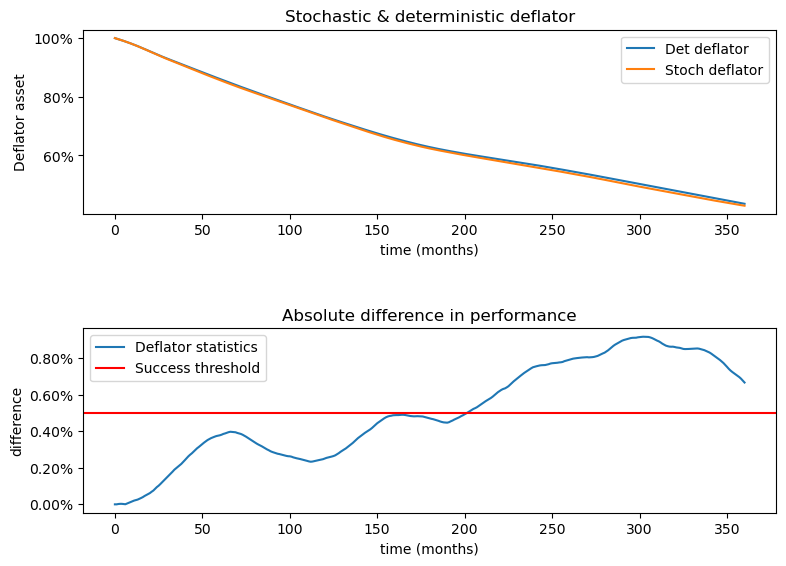

In [762]:
x_data_label = range(0,deflator_det.shape[0],1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(x_data_label, deflator_det.values*100, color='tab:blue',label="Det deflator")
ax1.plot(x_data_label, deflator_stoch_mean.values*100, color='tab:orange',label="Stoch deflator")
ax1.legend()
ax1.set_xlabel("time (months)")
ax1.set_ylabel("Deflator asset")
ax1.set_title('Stochastic & deterministic deflator')

ax2.plot(x_data_label, test_statistics_1*100, label="Deflator statistics")
ax2.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")
ax2.legend()
ax2.set_xlabel("time (months)")
ax2.set_ylabel("difference")
ax2.set_title('Absolute difference in performance')
fig.tight_layout(h_pad=2)

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(6)

plt.show()

[Back to the top](#0)
<a id="13"></a> <br>

## Test 1; Success criteria

The successful application of the success criteria marks the completion of the test

In [775]:
result1 = success_test(test_statistics_1, test_threshold_max, test_threshold_mean)

Test passed
Test passed


[Back to the top](#0)
<a id="14"></a> <br>

## Spot curve cumulative performance

The spot curve time-series contains annualized returns starting at every month. To calculate the cumulative performance for longer time periods, three extra steps must be performed:

1. Separate non-chained returns
2. Convert the annualized return into the actual return for the entire period
3. Aggregate the chained returns through time

The function spot_cumulative() applies the 3 steps above. This example is limited to terms 1 and 2 with terms 3 to 10 calculated in the <i>Extra content</i> section. It is possible to extend the methodology to higher terms.

In [778]:
def spot_cumulative(spot, term):
    out = (1+spot).pow(term)
    for iRow in range(term*12,out.shape[0]):
        out.iloc[iRow, :] = out.iloc[iRow, :]*out.iloc[iRow-term*12, :] 
    out = out.iloc[:(-term*12),:]
    return out

In [779]:
spot_1_cum = spot_cumulative(spot_1, 1)

In [780]:
spot_2_cum = spot_cumulative(spot_2, 2)

#### Extra content

In [782]:
spot_3_cum = spot_cumulative(spot_3, 3)
spot_4_cum = spot_cumulative(spot_4, 4)
spot_5_cum = spot_cumulative(spot_5, 5)

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Spot rate cumulative performance
</span>

In [791]:
spot_1_cum.head()

,SPOT_1,SPOT_1.1,SPOT_1.2,SPOT_1.3,SPOT_1.4,SPOT_1.5,SPOT_1.6,SPOT_1.7,SPOT_1.8,SPOT_1.9,...,SPOT_1.490,SPOT_1.491,SPOT_1.492,SPOT_1.493,SPOT_1.494,SPOT_1.495,SPOT_1.496,SPOT_1.497,SPOT_1.498,SPOT_1.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,...,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484,1.025484
31/10/2022,1.025951,1.024965,1.031043,1.021404,1.021871,1.033967,1.023326,1.025541,1.025197,1.027956,...,1.020897,1.029902,1.025875,1.021099,1.028071,1.021642,1.026177,1.029373,1.025478,1.022864
30/11/2022,1.026256,1.023438,1.028679,1.025185,1.027129,1.029316,1.034493,1.020698,1.025932,1.029994,...,1.024095,1.028359,1.023632,1.020485,1.008710,1.022090,1.022156,1.027993,1.016918,1.019003
31/12/2022,1.024064,1.023999,1.031913,1.029466,1.026192,1.024812,1.039323,1.023184,1.024342,1.030728,...,1.019358,1.031593,1.021744,1.029503,1.006404,1.022279,1.023948,1.027462,1.018420,1.014633
31/01/2023,1.024050,1.026649,1.033978,1.029959,1.036508,1.022529,1.045296,1.012303,1.029277,1.031384,...,1.020451,1.037064,1.031838,1.031011,1.013253,1.020579,1.019591,1.021532,1.022537,1.017642


In [792]:
spot_2_cum.head()

,SPOT_2,SPOT_2.1,SPOT_2.2,SPOT_2.3,SPOT_2.4,SPOT_2.5,SPOT_2.6,SPOT_2.7,SPOT_2.8,SPOT_2.9,...,SPOT_2.490,SPOT_2.491,SPOT_2.492,SPOT_2.493,SPOT_2.494,SPOT_2.495,SPOT_2.496,SPOT_2.497,SPOT_2.498,SPOT_2.499
VARIABLE_KEY,,,,,,,,,,,,,,,,,,,,,
30/09/2022,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,...,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721,1.058721
31/10/2022,1.059285,1.057306,1.069527,1.050177,1.051110,1.075431,1.054021,1.058461,1.057771,1.063311,...,1.049165,1.067228,1.059132,1.049568,1.063542,1.050653,1.059738,1.066164,1.058334,1.053097
30/11/2022,1.059411,1.053763,1.064278,1.057262,1.061163,1.065559,1.076002,1.048287,1.058760,1.066923,...,1.055077,1.063634,1.054150,1.047862,1.024487,1.051066,1.051200,1.062898,1.040754,1.044905
31/12/2022,1.054435,1.054305,1.070200,1.065274,1.058698,1.055934,1.085189,1.052674,1.054992,1.067813,...,1.045036,1.069555,1.049797,1.065349,1.019377,1.050866,1.054203,1.061247,1.043169,1.035641
31/01/2023,1.053745,1.058949,1.073692,1.065596,1.078806,1.050705,1.096655,1.030376,1.064225,1.068463,...,1.046557,1.079930,1.069377,1.067713,1.032255,1.046812,1.044843,1.048714,1.050720,1.040965


***

[Back to the top](#0)
<a id="15"></a> <br>

# Martingale tests

To evaluate the market-consistency, IVASS regulation 18 article 57 recommends to perform the Martingale test on asset classes used in the calibration process of the ESG and for simple financial strategies. 
The following asset classes are covered:

 - Spot curves

 - Total-return indices


Article 57 recommends using multiple simple investment strategies. Two are used in this example:

 - Forward return with a spread of 1 year

 - Buy-and-hold strategy

## Forward return with a spread of 1 year investment strategy

Forward return with a spread of `1`-year strategy consists of buying and selling fixed income assets in a way that the return is equal to a forward rate with constant maturity. In this example, a constant maturity of `1`-year is implemented by buying (long position) a ZCB with a maturity of `K+1` years and selling (short position) a ZCB with a maturity of `K`-years.

<font size=4>
$$ ZCB_{i,TK}(t) = \frac{1}{\big(1 + r_{i, TK}(t) \big)^K}  $$
</font>

<font size=4>
$$ Perf^{FR}_{i,TK,TK+1}(t) =\frac{ ZCB_{i,TK}(t)}{ ZCB_{i, TK+1}(t)} = $$
</font>

<font size=4>
$$ = \frac{\frac{1}{\big(1 + r_{i, TK}(t) \big)^{K}}}{\frac{1}{\big(1 + r_{i, TK+1}(t) \big)^{K+1}}} = \frac{\left( 1 + r_{i, TK+1}(t)\right)^{K+1}}{\left( 1 + r_{i, TK}(t) \right)^{K}} $$
</font>

Therefore:
<font size=4>
$$ DPerf^{FR}_{i,TK,TK+1}(t) = \frac{Perf^{FR}_{i,TK,TK+1}(t)}{\big(1+ r_{i,RF}(t+12*K)\big)} $$ 
</font>
is a Martingale. 

The test verifies the following asymptotic identity:

<font size=4>
$$ E^Q\big[Perf^{FR}_{i,TK,TK+1}(t)\big] =^? 1 $$
</font>

Where:

 - $Q$ is the numeraire used in this test which is the 1-year forward rate of the deflator 

The function forward_strategy_test() performs the beforementioned steps for any sequential spot rate terms

In [801]:
def forward_strategy_test(annualdef, spot, spotnext, term):
    if term>1:
        annualdef= annualdef.iloc[:-(term-1)*12,:]
        
    perf = ((1+spotnext).pow(term+1))/((1+spot).pow(term)).values
    perf_shifted = perf.shift(term*12)
    Mspot = perf_shifted.iloc[:-term*12,:].values/(1+annualdef).values
    Mspot = pd.DataFrame(Mspot)
    Mspot = Mspot.iloc[term*12:,:]
    return (Mspot - 1).mean(axis=1)

***

[Back to the top](#0)
<a id="16"></a> <br>

## Test 2; Forward return with a spread of 1-year investment strategy

Forward return with a spread of `1`-year strategy using `1`- and `2`-year spot rates consists of buying and selling ZCB bonds with `1`- and `2`-year term. In this example, this consists of buying (long position) a ZCB with a maturity of `2` years and selling (short position) a ZCB with a maturity of `1` year.

<font size=4>
$$ ZCB_{i,T1}(t) = \frac{1}{\big(1 + r_{i, T1}(t) \big)}  $$
</font>

<font size=4>
$$ ZCB_{i,T2}(t) = \frac{1}{\big(1 + r_{i, T2}(t) \big)^2}  $$
</font>

<font size=4>
$$ Perf^{FR}_{i,T1,T2}(t) = \frac{\left( 1 + r_{i, T2}(t)\right)^2}{\left( 1 + r_{i, T1}(t) \right)} $$
</font>

The strategy consists of selling the `1`-year ZCB bond and using the proceeds to buy a ZCB bond with a maturity of `2` years.

In a risk-neutral scenario this strategy can be replicated by depositing one unit at year `1` into the deflator asset and withdrawing it at time `2`. 


Therefore:
<font size=4>
$$ DPerf^{FR}_{i,T1,T2}(t) = \frac{Perf^{FR}_{i,T1,T2}(t)}{\big(1+ r_{i,RF}(t+12)\big)} $$ 
</font>

The test verifies the following asymptotic identity:

<font size=4>
$$ E^Q\big[Perf^{FR}_{i,T1,T2}(t)\big] =^? 1 $$
</font>

Where:

 - $Q$ is the numeraire used in this test which is the 1-year forward rate of the deflator 

The two test statistics used are:

<font size=4>$$ S_{AVERAGE} = \frac{1}{T-12} \sum_{t = 0}^{T-12}\frac{1}{N} \sum_{i = 0}^N \big| DPerf^{FR}_{i,T1,T2}(t) - 1 \big| $$</font>

<br>

<font size=4>$$ S_{MAX} = \max_t \frac{1}{N} \bigg| \sum_{i = 0}^N (DPerf^{FR}_{i,T1,T2}(t) - 1)  \bigg| $$</font>

In [809]:
test_statistics_2 = forward_strategy_test(r_d_12_t, spot_1, spot_2, 1)

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    Forward return strategy using the 1- and 2-year spot rate
</span>

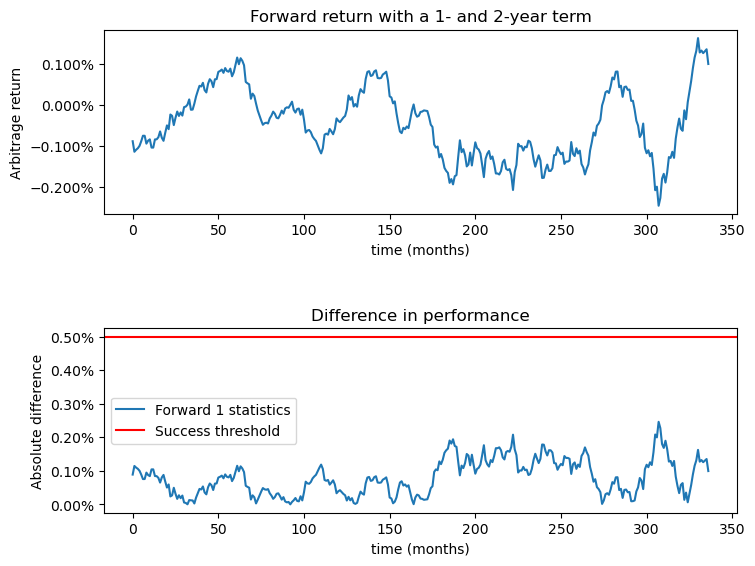

In [811]:
x_data_label = range(0,test_statistics_2.shape[0],1)
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(x_data_label, test_statistics_2.values*100, color='tab:blue')

ax1.set_xlabel("time (months)")
ax1.set_ylabel("Arbitrage return")
ax1.set_title('Forward return with a 1- and 2-year term')

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2.plot(x_data_label, np.abs(test_statistics_2)*100, label="Forward 1 statistics")
ax2.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")
ax2.legend()
ax2.set_xlabel("time (months)")
ax2.set_ylabel("Absolute difference")
ax2.set_title('Difference in performance')
fig.tight_layout(h_pad=2)

ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(8)
fig.set_figheight(6)

plt.show()

[Back to the top](#0)
<a id="17"></a> <br>

## Test 2; Success criteria

The successful application of the success criteria marks the completion of the test

In [814]:
result2 = success_test(np.abs(test_statistics_2), test_martingale_threshold_max, test_martingale_threshold_mean)

Test passed
Test passed


#### EXTRA CONTENT

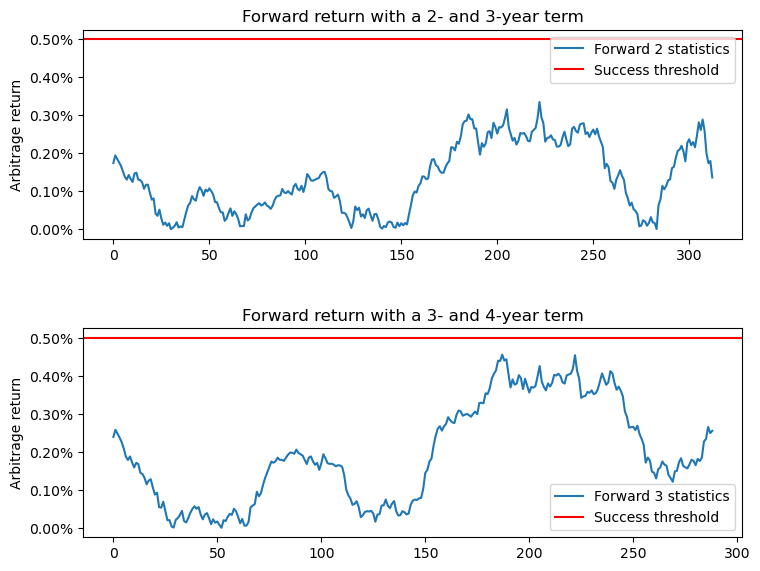

In [816]:
test2_diff_2 = forward_strategy_test(r_d_12_t, spot_2, spot_3, 2)
test2_diff_3 = forward_strategy_test(r_d_12_t, spot_3, spot_4, 3)

x_data_label_2 = range(0,test2_diff_2.shape[0],1)
x_data_label_3 = range(0,test2_diff_3.shape[0],1)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(x_data_label_2, np.abs(test2_diff_2).values*100, color='tab:blue', label="Forward 2 statistics")
ax1.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")
ax1.set_title('Forward return with a 2- and 3-year term')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_ylabel("Arbitrage return")
ax1.legend()
ax2.plot(x_data_label_3, np.abs(test2_diff_3).values*100, color='tab:blue', label="Forward 3 statistics")
ax2.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_title('Forward return with a 3- and 4-year term')
ax2.set_ylabel("Arbitrage return")
ax2.legend()
fig.tight_layout(h_pad=2)
fig.set_figwidth(8)
fig.set_figheight(6)

plt.show()

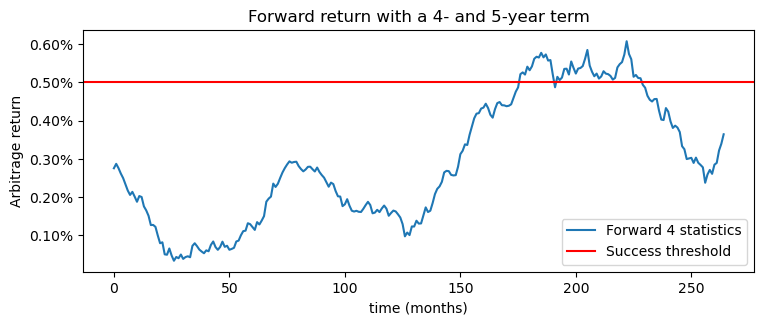

In [817]:
test2_diff_4 = forward_strategy_test(r_d_12_t, spot_4, spot_5, 4)

x_data_label_4 = range(0,test2_diff_4.shape[0],1)

fig, ax3 = plt.subplots(1,1)

ax3.plot(x_data_label_4, np.abs(test2_diff_4).values*100, color='tab:blue', label="Forward 4 statistics")
ax3.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.set_ylabel("Arbitrage return")
ax3.set_title('Forward return with a 4- and 5-year term')
ax3.set_xlabel("time (months)")
ax3.legend()
fig.tight_layout(h_pad=2)
fig.set_figwidth(8)
fig.set_figheight(3)

plt.show()

***

[Back to the top](#0)
<a id="18"></a> <br>

## Test 3; Buy-and-hold investment strategy

The Buy-and-hold strategy consists of investing all funds into ZCBs of a selected maturity, holding them until maturity and rolling all proceeds to buy another round of ZCB with the same selected maturity.

The strategy consists of investing for example `1` unit of currency in month `k` and withdrawing the accrued payoff at time `T`.

`k` is one of the first $K*12$ months where $K$ is the term of the spot rate curve used.

This payoff can be replicated by investing the initial amount in a risk-free asset represented by the deflator asset at time `k` and withdrawing everything at the end time `T`.

If the strategy has a term of `K` years, $K*12$ separate starting points need to be tested (to cover the entire curve). For each starting point, the performance can be calculated as:

$$ Perf^{BH}_{i,TK,k} (t`)= \prod_{j = 0}^{t`} \left( (1+r_{i,TK}(k+12 K j) \right)^K $$

Where $t` = 1,2,3,...$. Note that $t`$ represents year multiples of the selected term $K$.

Therefore:

$$ DPerf^{BH}_{i,TK,k} (t`) =  Perf^{BH}_{i,TK,k} (t`) * ZCB_{i, RF}(0,k+12 K t`) $$ 

is a Martingale and therefore the test verifies the following asymptotic identity:

$$ E^{Q_k}\big[Perf^{BH}_{i,TK,k} (t`)\big] =^? 1 $$

Where:

 - $Q$ is the numeraire used in this test which is the terminal value of the deflator asset starting at time `k`


The function deflator_normalisation() normalizes the deflator asset such that the resulting series has a value of `1` at starting month `k`.

In [823]:
def deflator_normalisation(deflator, n):
    out = deflator.copy()
    for iRow in range(0,out.shape[0]):
        out.iloc[iRow,:] = out.iloc[iRow,:]/deflator.iloc[iRow % (n*12),:] #ToDo modulo in python
    out = out.iloc[n*12:,:]    
    return out

The function month_decomposition() separates the time-series that starts at each month in a separate row, making it possible to compare them.

In [825]:
def month_decomposition(data, term):
    years = int(np.floor(data.shape[0]/(term*12)))-1
    out = np.zeros((years,term*12))

    for iStart in range(0,years*(term*12),1):
        position = iStart%(term*12)
        time = int(np.floor(iStart/(term*12)))
        out[time,position] = data[iStart]
    return out   

[Back to the top](#0)
<a id="19"></a> <br>

#### Test 3.1;Spot rate 1-year term

$$ Perf^{BH}_{i,T1,k} (t`)= \prod_{j = 0}^{t`} \left( 1+r_{i,T1}(k+12*j) \right) $$

Where $t` = 1, 2, 3, ...$ and $k = 0, 1, 2, \dots, 11$

Therefore 

$$ DPerf^{BH}_{i,T1,k} (t`) =  Perf^{BH}_{i,T1,k} (t`) * ZCB_{i, RF}(0,k+t`*12) $$ 

is a Martingale and therefore the test verifies the following asymptotic identity

$$ E^{Q_k}\big[Perf^{BH}_{i,T1,k} (t`)\big] =^? 1 $$


The two test statistics used are:

<font size=4>$$ S_{AVERAGE} = \frac{1}{T`} \sum_{t` = 0}^{T`} \frac{1}{N} \big| \sum_{i = 0}^N (DPerf^{BH}_{i,T1,k} (t`) - 1) \big| $$</font>

<br>

<font size=4>$$ S_{MAX} = \max_{t`} \frac{1}{N} \big| \sum_{i = 0}^N (DPerf^{BH}_{i,T1,k} (t`) - 1)  \big| $$</font>

In [829]:
deflator_1 = deflator_normalisation(deflator, 1)
MPerf1 = pd.DataFrame(spot_1_cum.values*deflator_1.values)

In [830]:
test_statistics_3_1 = (MPerf1 - 1).mean(axis=1)

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
   1-year Buy-and-hold strategy test
</span>

In [832]:
MPerf1.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.004562,0.999219,0.991150,1.003348,0.993555,1.004531,0.987302,1.006627,0.996127,1.003108,...,1.005866,0.989069,0.992759,1.006712,1.004969,1.001652,1.004612,1.002714,1.007048,1.015211
1,1.003213,0.997795,0.993088,0.999417,0.987495,1.013388,0.983262,1.005822,0.995352,1.007171,...,1.000586,0.990931,0.991782,1.003596,1.006347,0.996530,1.004242,1.005712,1.006707,1.014475
2,1.001956,0.995144,0.987677,1.002524,0.990338,1.009810,0.991778,1.000620,0.994519,1.011014,...,1.003072,0.987275,0.988319,1.004111,0.986631,0.995712,0.999514,1.003652,0.997309,1.012315
3,0.998350,0.994125,0.987555,1.006513,0.987055,1.005991,0.994121,1.002615,0.991917,1.012795,...,0.998028,0.987896,0.984851,1.013453,0.981520,0.993935,1.000180,1.002491,0.997266,1.009101
4,0.996157,0.995422,0.986971,1.007133,0.994106,1.004390,0.997618,0.992355,0.995912,1.014328,...,0.998254,0.990771,0.992474,1.015249,0.984867,0.989628,0.995137,0.995261,0.999849,1.012831


In [833]:
plot_strategy_1 = month_decomposition(test_statistics_3_1, 1)

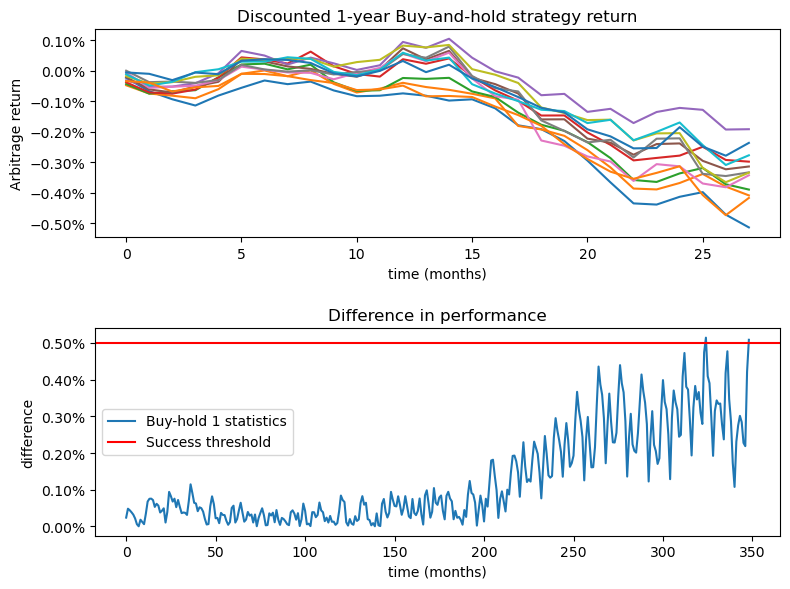

In [834]:
x_data_label_1 = range(0,plot_strategy_1.shape[0],1)
x_data_label_2 = range(0,test_statistics_3_1.shape[0],1)

fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(x_data_label_1, plot_strategy_1*100)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_xlabel("time (months)")
ax1.set_ylabel("Arbitrage return")
ax1.set_title('Discounted 1-year Buy-and-hold strategy return')

ax2.plot(x_data_label_2, np.abs(test_statistics_3_1)*100, label="Buy-hold 1 statistics")
ax2.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")

ax2.set_xlabel("time (months)")
ax2.set_ylabel("difference")
ax2.set_title('Difference in performance')
fig.tight_layout(h_pad=2)
ax2.legend()
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(6)

fig.tight_layout(h_pad=2)

plt.show()

[Back to the top](#0)
<a id="20"></a> <br>

## Test 3.1; Success criteria

The successful application of the success criteria marks the completion of the test

In [836]:
result31 = success_test(np.abs(test_statistics_3_1), test_martingale_threshold_max, test_martingale_threshold_mean)

Test passed
Test passed


***

[Back to the top](#0)
<a id="21"></a> <br>

#### Test 3.2; Spot rate 2-year term

$$ Perf^{BH}_{i,T2,k} (t`)= \prod_{j = 0}^{t`} \left( (1+r_{i,T2}(k+24j) \right)^2 $$

Where $t` = 1, 2, 3, ...$ and $k = 0, 1, 2, \dots, 23$.

Therefore 

$$ DPerf^{BH}_{i,T2,k} (t`) =  Perf^{BH}_{i,T2,k} (t`) * ZCB_{i, RF}(0,k+24t`) $$ 

is a Martingale and therefore the test verifies the following asymptotic identity:

$$ E^{Q_k}\big[Perf^{BH}_{i,T2,k} (t`)\big] =^? 1 $$


The two test statistics used are:

<font size=4>$$ S_{AVERAGE} = \frac{1}{T-24} \sum_{t = 0}^T \big| \frac{1}{N} \sum_{i = 0}^N  (DPerf^{BH}_{i,T2,k} (t) - 1) \big| $$</font>

<br>

<font size=4>$$ S_{MAX} = \max_t \big|\frac{1}{N} \sum_{i = 0}^N (DPerf^{BH}_{i,T2,k} (t) - 1)  \big| $$</font>

In [841]:
deflator_2 = deflator_normalisation(deflator, 2)
MPerf2 = pd.DataFrame(spot_2_cum.values*deflator_2.values)

In [842]:
test_statistics_3_2 = (MPerf2 - 1).mean(axis=1)

***
<span style=color:silver>
    <b>VISUAL INSPECTION</b>
</span>
<br>
<span style=color:silver>   
    2-year Buy-and-hold strategy test
</span>

In [844]:
MPerf2.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.987804,0.995772,0.958710,1.023029,0.966309,1.024074,0.957349,1.010823,1.005664,1.022176,...,1.017128,0.972413,0.986842,1.015954,0.993610,0.990125,0.999217,0.996569,1.014536,1.044291
1,0.986066,0.992620,0.965574,1.017481,0.956770,1.039609,0.950018,1.010024,1.005465,1.026817,...,1.008156,0.978269,0.985488,1.006890,0.995958,0.981113,0.998096,1.003136,1.013737,1.040211
2,0.984107,0.987466,0.958412,1.026432,0.963630,1.030374,0.966157,1.000004,1.007448,1.031612,...,1.013869,0.973820,0.978974,1.004639,0.957384,0.979795,0.988150,0.999873,0.995640,1.034115
3,0.977909,0.985546,0.961410,1.036239,0.960092,1.020917,0.971313,1.003374,1.004735,1.033812,...,1.004674,0.978008,0.972903,1.020778,0.948895,0.977734,0.988632,0.997856,0.996031,1.026409
4,0.975116,0.987340,0.962555,1.039016,0.976373,1.015152,0.978943,0.981117,1.014926,1.036062,...,1.005777,0.986106,0.988721,1.023611,0.957155,0.972586,0.977612,0.986324,1.001435,1.032183


In [845]:
plot_strategy_2 = month_decomposition(test_statistics_3_2, 2)

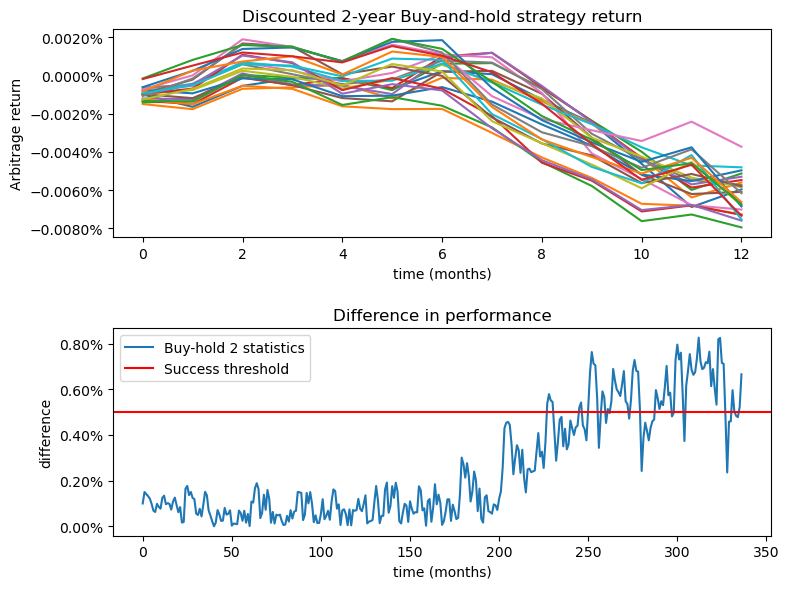

In [846]:
x_data_label_1 = range(0,plot_strategy_2.shape[0],1)
x_data_label_2 = range(0,test_statistics_3_2.shape[0],1)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(x_data_label_1, plot_strategy_2)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax1.set_xlabel("time (months)")
ax1.set_ylabel("Arbitrage return")
ax1.set_title('Discounted 2-year Buy-and-hold strategy return')

ax2.plot(x_data_label_2, np.abs(test_statistics_3_2)*100, label="Buy-hold 2 statistics")
ax2.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")

ax2.set_xlabel("time (months)")
ax2.set_ylabel("difference")
ax2.set_title('Difference in performance')
fig.tight_layout(h_pad=2)
ax2.legend()
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(6)

fig.tight_layout(h_pad=2)

plt.show()

[Back to the top](#0)
<a id="22"></a> <br>

## Test 3.2; Success criteria

The successful application of the success criteria marks the completion of the test

In [848]:
result32 = success_test(np.abs(test_statistics_3_2), test_martingale_threshold_max, test_martingale_threshold_mean)

Test passed
Test passed


### Extra content

In [850]:
deflator_3 = deflator_normalisation(deflator, 3)
MPerf3 = pd.DataFrame(spot_3_cum.values*deflator_3.values)
test3_diff_3 = (MPerf3 - 1).mean(axis=1)
plot_strategy_3 = month_decomposition(test3_diff_3, 3)

In [851]:
deflator_4 = deflator_normalisation(deflator, 4)
MPerf4 = pd.DataFrame(spot_4_cum.values*deflator_4.values)
test3_diff_4 = (MPerf4 - 1).mean(axis=1)
plot_strategy_4 = month_decomposition(test3_diff_4, 4)

In [852]:
deflator_5 = deflator_normalisation(deflator,5)
MPerf5 = pd.DataFrame(spot_5_cum.values*deflator_5.values)
test3_diff_5 = (MPerf5 - 1).mean(axis=1)
plot_strategy_5 = month_decomposition(test3_diff_5, 5)

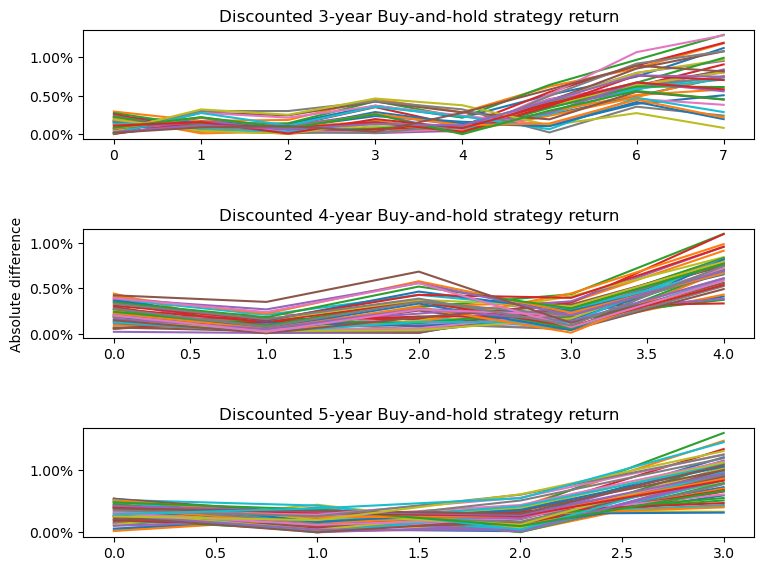

In [853]:
x_data_label_3 = range(0,plot_strategy_3.shape[0],1)
x_data_label_4 = range(0,plot_strategy_4.shape[0],1)
x_data_label_5 = range(0,plot_strategy_5.shape[0],1)

fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.plot(x_data_label_3, np.abs(plot_strategy_3)*100)
ax1.set_title('Discounted 3-year Buy-and-hold strategy return')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2.plot(x_data_label_4, np.abs(plot_strategy_4)*100)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylabel("Absolute difference")
ax2.set_title('Discounted 4-year Buy-and-hold strategy return')

ax3.plot(x_data_label_5, np.abs(plot_strategy_5)*100)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.set_title('Discounted 5-year Buy-and-hold strategy return')

fig.tight_layout(h_pad=2)

fig.set_figwidth(8)
fig.set_figheight(6)

plt.show()

***

[Back to the top](#0)
<a id="23"></a> <br>

## Test 4; Total-return index

The total-return index in a risk-neutral framework has on average the same performance as the stochastic deflator asset. 

$$  DPerf^{I}_{i, 1}(t) = I_{i, 1}(t) * ZCB_{i, RF}\big(0,t\big)  $$

Therefore, the performance of the index is a Martingale if the deflator asset is used as the numeraire:

$$ E^{Q}\big[I_{i, 1}(t)\big] =^? 1 $$

Where:

 - $Q$ is the numeraire used in this test which is the deflator asset at time `t`


The two test statistics used are:

<font size=4>$$ S_{AVERAGE} = \frac{1}{T} \sum_{t = 0}^T \frac{1}{N} \big| \sum_{i = 0}^N  DPerf^{I}_{i, 1}(t) - 1 \big| $$</font>

<br>

<font size=4>$$ S_{MAX} = \max_t \frac{1}{N} \big| \sum_{i = 0}^N (DPerf^{I}_{i, 1}(t) - 1)  \big| $$</font>

In [858]:
test_statistics_4 = pd.DataFrame(first_index.values * deflator.values).mean(axis=1)-1

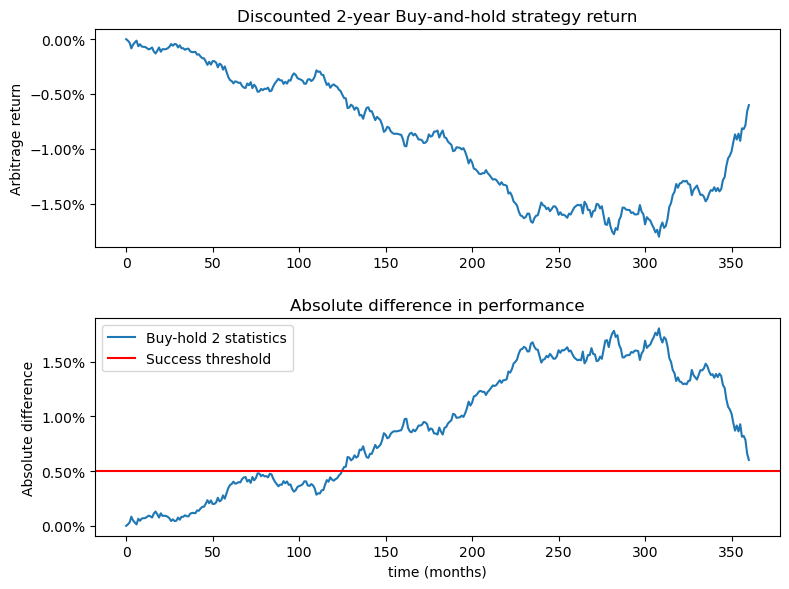

In [860]:
x_data_label = range(0,test_statistics_4.shape[0],1)

fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(x_data_label, test_statistics_4.values*100, color='tab:blue')

ax1.set_ylabel("Arbitrage return")
ax1.set_title('Discounted 2-year Buy-and-hold strategy return')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2.plot(x_data_label, np.abs(test_statistics_4)*100, label="Buy-hold 2 statistics")
ax2.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")

ax2.set_xlabel("time (months)")
ax2.set_ylabel("Absolute difference")
ax2.set_title('Absolute difference in performance')
fig.tight_layout(h_pad=2)
ax2.legend()
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(6)

fig.tight_layout(h_pad=2)

plt.show()

[Back to the top](#0)
<a id="24"></a> <br>

## Test 4; Success criteria

The successful application of the success criteria marks the completion of the test.

In [862]:
result4 = success_test(np.abs(test_statistics_4), test_martingale_threshold_max, test_martingale_threshold_mean)

Test failed
Test failed


[Back to the top](#0)
<a id="25"></a> <br>

## Conclusion

This script conducted tests on the output of the stochastic scenario output. The files selected are:

In [864]:
file_det

'TEST_DATA_DETERMINISTIC.csv'

In [865]:
file_stoch

'TEST_DATA_STOCHASTIC.csv'

The currency selected for this run is

In [867]:
currency

'EUR'

Test 1 compares the average performance of the stochastic deflator asset compared with the deterministic deflator asset.

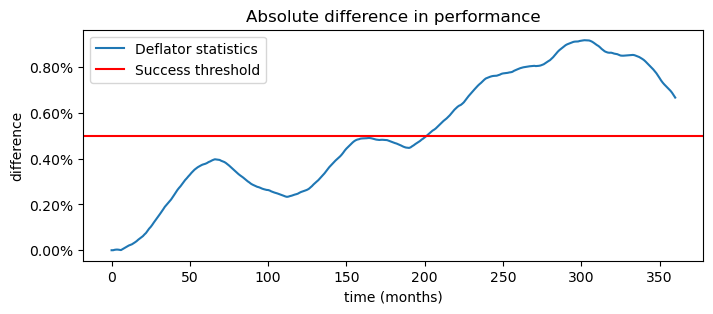

In [869]:
x_data_label = range(0,deflator_det.shape[0],1)
fig, ax = plt.subplots(1,1)
ax.plot(x_data_label, test_statistics_1*100, label="Deflator statistics")
ax.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")

ax.set_xlabel("time (months)")
ax.set_ylabel("difference")
ax.set_title('Absolute difference in performance')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(3)

plt.show()

Test 2 performs a Martingale test on a specific investment strategy using spot curves.The Forward return with a spread of `1`-year strategy using `1`- and `2`-year spot rates consists of buying and selling ZCB bonds with `1`- and `2`-year term. In this example, this consists of buying (long position) a ZCB with a maturity of `2` years and selling (short position) a ZCB with a maturity of `1` year.

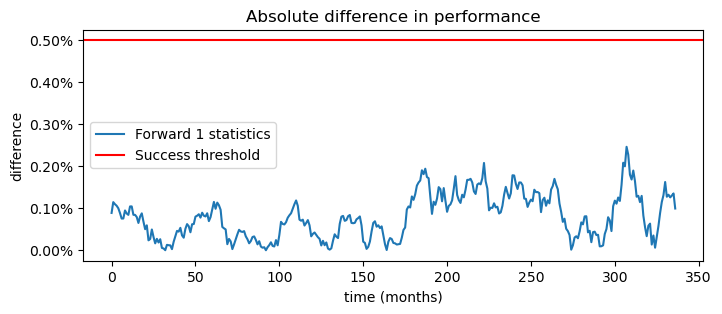

In [871]:
x_data_label = range(0,test_statistics_2.shape[0],1)
fig, ax = plt.subplots(1,1)
ax.plot(x_data_label, np.abs(test_statistics_2)*100, label="Forward 1 statistics")
ax.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")
ax.legend()
ax.set_xlabel("time (months)")
ax.set_ylabel("difference")
ax.set_title('Absolute difference in performance')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(8)
fig.set_figheight(3)

plt.show()

Tests 3.1 and 3.2 perform a Martingale test on the second financial strategy using spot rate curves. This Buy-and-hold strategy consists of investing all funds into ZCBs of a selected maturity, holding them until maturity and rolling all proceeds to buy another round of ZCB with the same selected maturity.

Test 3.1 uses the `1`-year spot curve.

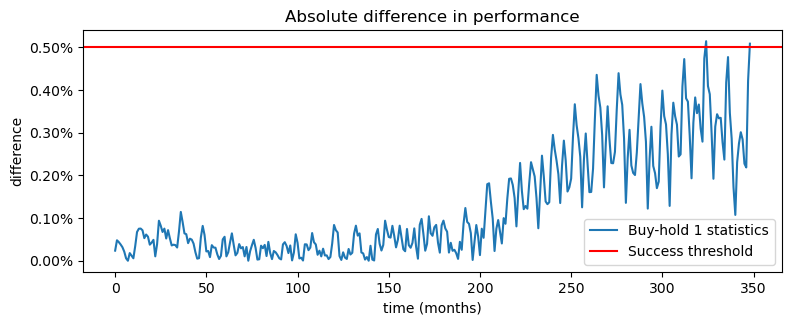

In [874]:
x_data_label_2 = range(0,test_statistics_3_1.shape[0],1)

fig, ax = plt.subplots(1, 1)

ax.plot(x_data_label_2, np.abs(test_statistics_3_1)*100, label="Buy-hold 1 statistics")
ax.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")
ax.legend()
ax.set_xlabel("time (months)")
ax.set_ylabel("difference")
ax.set_title('Absolute difference in performance')
fig.tight_layout(h_pad=2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(3)

plt.show()

Test 3.2 uses the `2`-year spot curve.

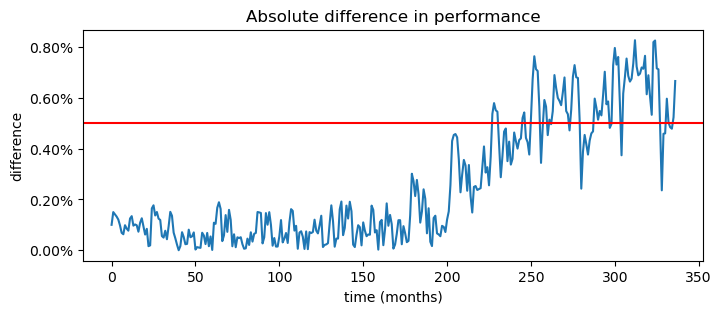

In [876]:
x_data_label_2 = range(0,test_statistics_3_2.shape[0],1)

fig, ax = plt.subplots(1,1)

ax.plot(x_data_label_2, np.abs(test_statistics_3_2)*100, label="Buy-hold 2 statistics")
ax.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")

ax.set_xlabel("time (months)")
ax.set_ylabel("difference")
ax.set_title('Absolute difference in performance')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(3)

plt.show()

Test 4 performs the Martingale test using the total-return index. This test checks if the performance of the index using the deflator as numeraire is a Martingale. 


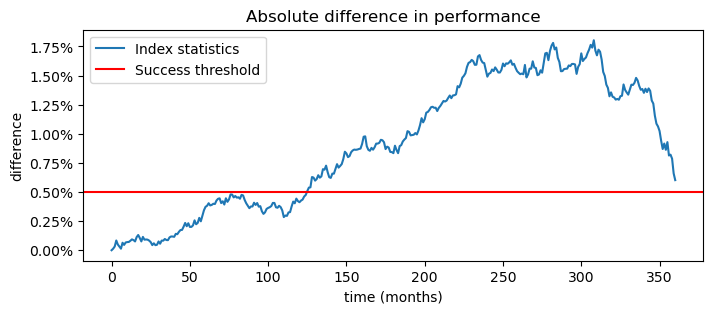

In [878]:
x_data_label = range(0,test_statistics_4.shape[0],1)

fig, ax = plt.subplots(1,1)

ax.plot(x_data_label, np.abs(test_statistics_4)*100, label="Index statistics")
ax.axhline(y = test_martingale_threshold_mean*100, color = 'r', label="Success threshold")

ax.set_xlabel("time (months)")
ax.set_ylabel("difference")
ax.set_title('Absolute difference in performance')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.set_figwidth(8)
fig.set_figheight(3)

plt.show()

Given the success criteria, the tests show the following success rate:

In [881]:
pd.DataFrame(data = [result1, result2, result31, result32, result4], columns = ["Mean test","Max test"],  \
             index= ["Deflator/deterministic","Martingale Forward return 12", "Martingale Buy-and-hold 1",\
                     "Martingale Buy-and-hold 2","Martingale Total-return index"]) 

,Mean test,Max test
Deflator/deterministic,True,True
Martingale Forward return 12,True,True
Martingale Buy-and-hold 1,True,True
Martingale Buy-and-hold 2,True,True
Martingale Total-return index,False,False
